In [4]:
!pip install pmdarima

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.linear_model import LinearRegression
from google.colab import drive
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
drive.mount('/content/drive')

appliances = ['Washer Dryer',]
# #  'Washer Dryer', 'Washing Machine',
#        'Dishwasher', 'Television', 'Microwave', 'Kettle', 'Hi-Fi',
#       'h_power']
c_data = pd.read_csv('/content/drive/MyDrive/grouped_power_data_3.csv')
randy_date = pd.to_datetime('2014-03-27').tz_localize('UTC')
c_data['Time'] = pd.to_datetime(c_data['Time'])
c_data.set_index('Time', inplace=True)
c_data = c_data[c_data.index < randy_date].copy()
c_data.index = pd.date_range(start=c_data.index.min(), end=c_data.index.max(), freq='T')
trial = c_data[1:50000]
print(c_data[:1], c_data.shape)
print(trial[:0], trial.shape)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.7 MB/s eta 0:00:00
Mounted at /content/drive
                           Aggregate  Washer Dryer  Washing Machine  \
2013-12-17 17:26:00+00:00        395             0                0   

                           Dishwasher  Television  Minute  Hour  day  \
2013-12-17 17:26:00+00:00           0           2      26    17    1   

                           Temperature  Humidity        Date  h_power  \
2013-12-17 17:26:00+00:00    -0.088889      1.72  2013-12-17      395   

                           Washer Dryer_state  Washing Machine_state  \
2013-12-17 17:26:00+00:00                   0                      0   

                           Dishwasher_state  Television_state  
2013-12-17 17:26:00+00:00                 0                 1   (142954, 16)
Empty DataFrame
Columns: [Aggregate, Washer Dryer, Washing Machine, Dishwasher, Television, Minute, Hour, day, Temperature, Humidity, Date, h_power, Washer Dryer_state, Washing

In [5]:
from scipy.stats.mstats import winsorize
import seaborn as sns

columns = ['Washer Dryer', 'Washing Machine', 'Dishwasher',
'Television', 'h_power']
scaler = MinMaxScaler()

c_data[columns] = scaler.fit_transform(c_data[columns])
# f_data = f_data.drop(columns=dropped)

print(c_data.index)


# c_data['Date'] = c_data.index.date
c_data = c_data.fillna(0)
# reference_date = min(c_data['Date'])

# c_data['date'] = (c_data['Date'] - reference_date).dt.days
# c_data.set_index(keys=['Time'], inplace=True )

c_data['Washer Dryer'] = winsorize(c_data['Washer Dryer'], limits=[0, 0])
c_data['Washing Machine'] = winsorize(c_data['Washing Machine'], limits=[0, 0])
c_data['Dishwasher'] = winsorize(c_data['Dishwasher'], limits=[0, 0])
c_data['Television'] = winsorize(c_data['Television'], limits=[0, 0.05])

DatetimeIndex(['2013-12-17 17:26:00+00:00', '2013-12-17 17:27:00+00:00',
               '2013-12-17 17:28:00+00:00', '2013-12-17 17:29:00+00:00',
               '2013-12-17 17:30:00+00:00', '2013-12-17 17:31:00+00:00',
               '2013-12-17 17:32:00+00:00', '2013-12-17 17:33:00+00:00',
               '2013-12-17 17:34:00+00:00', '2013-12-17 17:35:00+00:00',
               ...
               '2014-03-26 23:50:00+00:00', '2014-03-26 23:51:00+00:00',
               '2014-03-26 23:52:00+00:00', '2014-03-26 23:53:00+00:00',
               '2014-03-26 23:54:00+00:00', '2014-03-26 23:55:00+00:00',
               '2014-03-26 23:56:00+00:00', '2014-03-26 23:57:00+00:00',
               '2014-03-26 23:58:00+00:00', '2014-03-26 23:59:00+00:00'],
              dtype='datetime64[ns, UTC]', length=142954, freq='T')


In [7]:
c_data['dow'] = c_data.index.dayofweek
c_data['doy'] = c_data.index.dayofyear
c_data['year'] = c_data.index.year
# c_data['month'] = c_data.index.month
# c_data['quarter'] = c_data.index.quarter
c_data['weekday'] = c_data.index.day_name()
# c_data['woy'] = c_data.index.weekofyear
c_data['dom'] = c_data.index.day # Day of Month
c_data['date'] = c_data.index.date
# c_data['season'] = c_data['month'].apply(lambda month_number: (month_number%12 + 3)//3)
c_data['IsHoliday'] = c_data['dow'].isin(['Saturday', 'Sunday']).astype(int)
c_data['IsMorning'] = c_data['Hour'].between(6, 12).astype(int)
print(c_data.index.max())
# c_data.set_index('Time', inplace=True)
# c_data.index = pd.date_range(start=c_data.index.min(), end=c_data.index.max(), freq='H')
for appliance in columns:
  c_data[f'{appliance}EMA'] = c_data[appliance].ewm(span=3, adjust=False).mean()
  c_data['RollingMean'] = c_data[appliance].rolling(window=3).mean()
  c_data['RollingStd'] = c_data[appliance].rolling(window=3).std()
  c_data[f'{appliance}_Usage_t-1'] = c_data[appliance].shift(1)
  c_data[f'{appliance}_Usage_t-2'] = c_data[appliance].shift(2)

2014-03-26 23:59:00+00:00


<Figure size 1200x600 with 0 Axes>

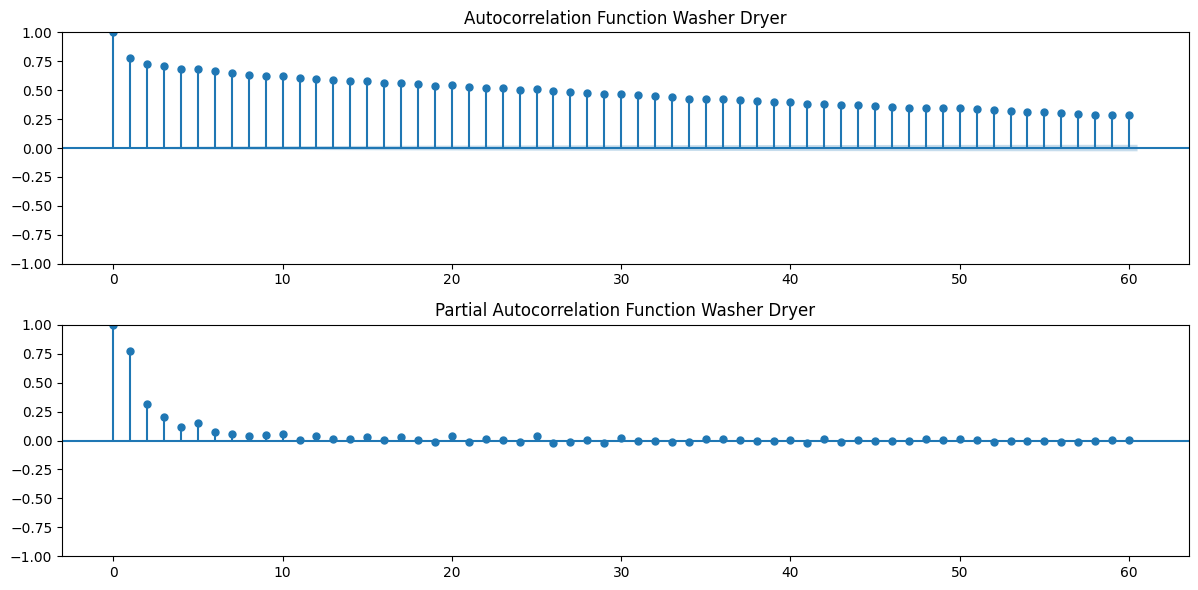

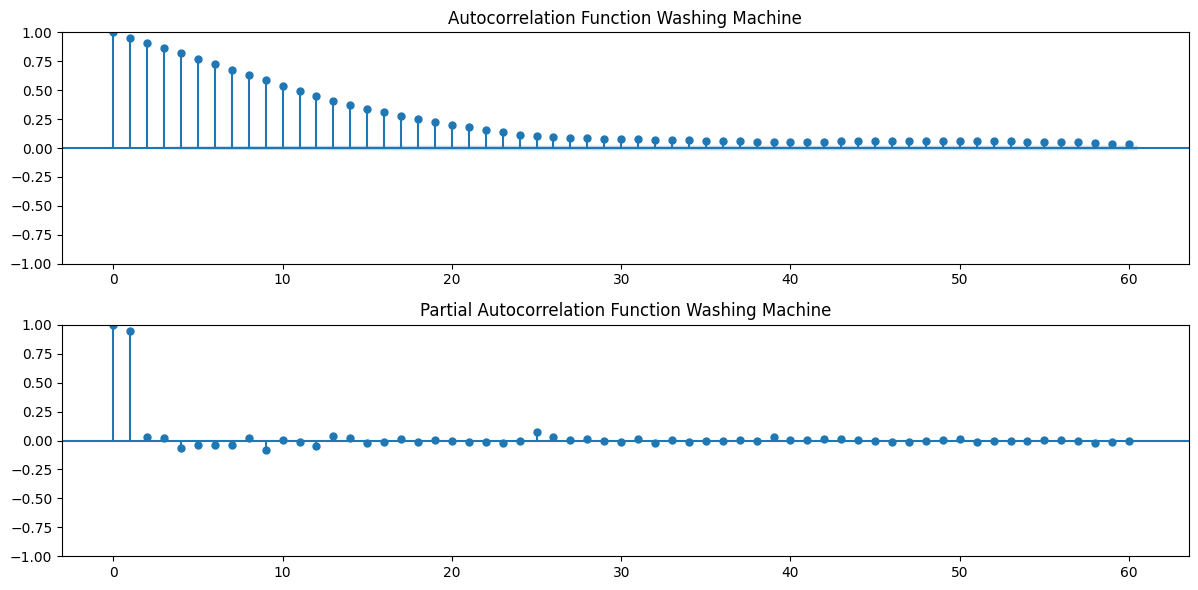

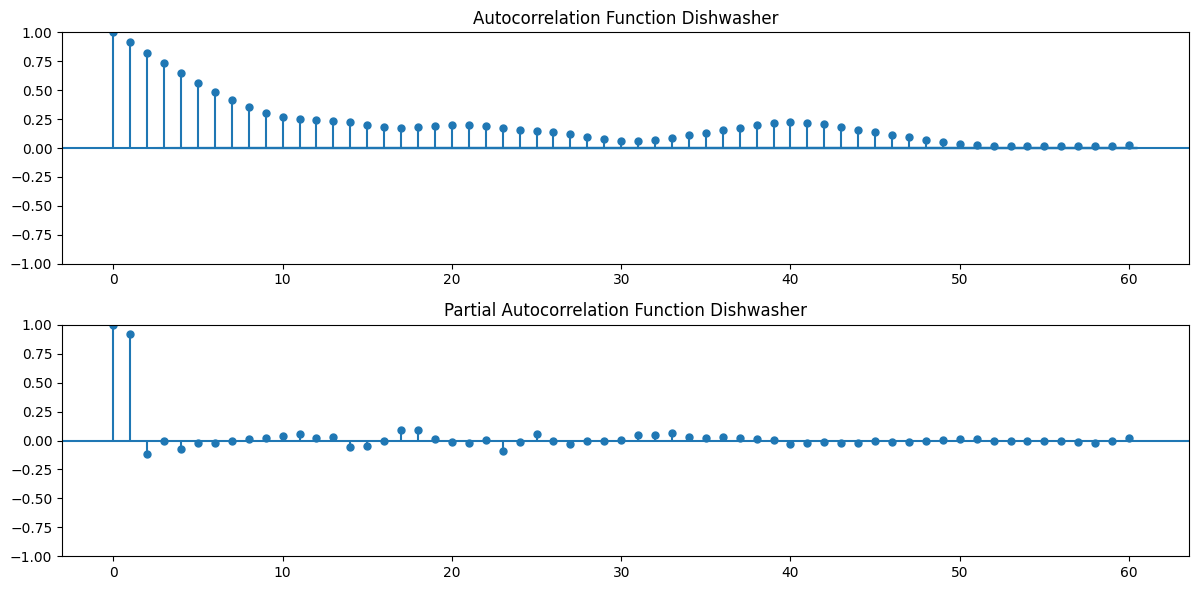

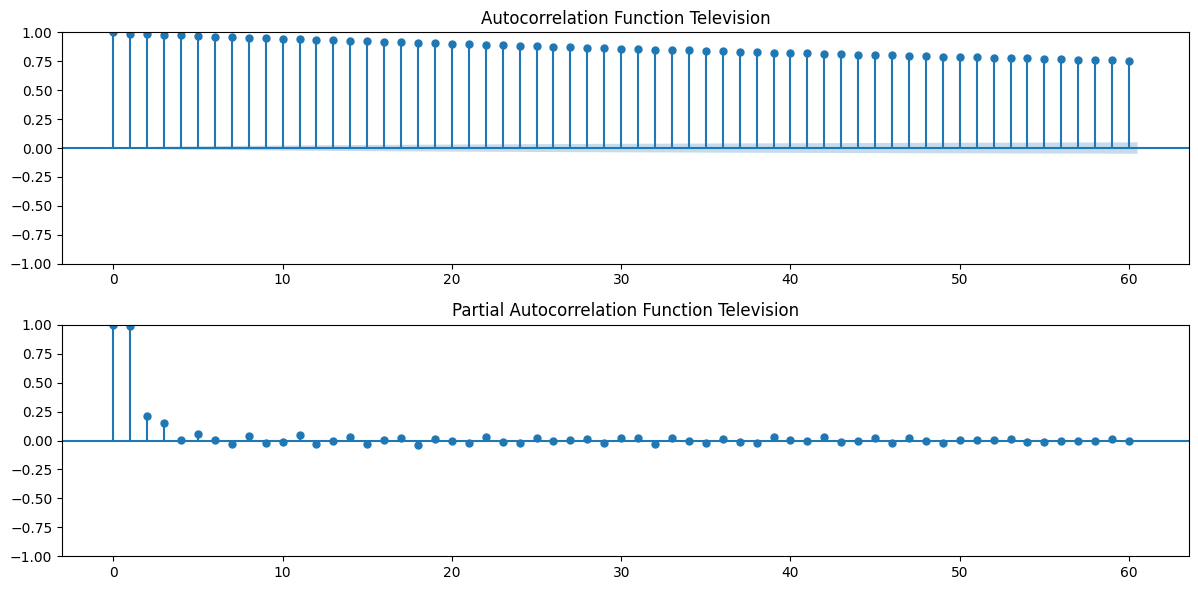

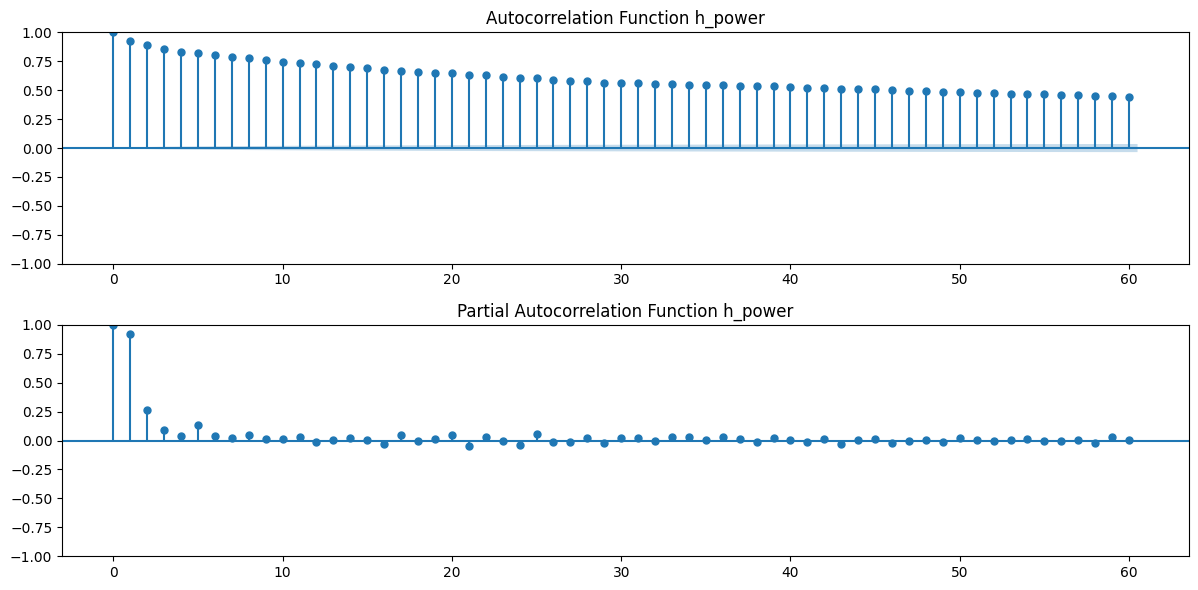

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
plt.figure(figsize=(12, 6))
for i in columns:
  plt.figure(figsize=(12, 6))
  plt.subplot(2, 1, 1)
  plot_acf(c_data[i], lags=60, ax=plt.gca())
  plt.title(f'Autocorrelation Function {i}')

  plt.subplot(2, 1, 2)
  plot_pacf(c_data[i], lags=60, ax=plt.gca())
  plt.title(f'Partial Autocorrelation Function {i}')


  plt.tight_layout()
  plt.show()


In [9]:
for i in columns:
  adfuller_result = adfuller(c_data[i])
  print(i)
  print('ADF Statistic:', adfuller_result[0])
  print('p-value:', adfuller_result[1])
  print('Critical Values:', adfuller_result[4])
  if adfuller_result[1] <= 0.05:
        print("Stationary (reject the null hypothesis)")
  else:
        print("Non-Stationary (fail to reject the null hypothesis)")
print(c_data.columns)

Washer Dryer
ADF Statistic: -26.914902516013704
p-value: 0.0
Critical Values: {'1%': -3.4303957689197704, '5%': -2.8615602292123787, '10%': -2.5667807672902248}
Stationary (reject the null hypothesis)
Washing Machine
ADF Statistic: -37.34750932455173
p-value: 0.0
Critical Values: {'1%': -3.430395768279101, '5%': -2.861560228929214, '10%': -2.5667807671395058}
Stationary (reject the null hypothesis)
Dishwasher
ADF Statistic: -26.213302397787825
p-value: 0.0
Critical Values: {'1%': -3.4303957689197704, '5%': -2.8615602292123787, '10%': -2.5667807672902248}
Stationary (reject the null hypothesis)
Television
ADF Statistic: -16.46648692897191
p-value: 2.3042639614050653e-29
Critical Values: {'1%': -3.4303957685994337, '5%': -2.8615602290707955, '10%': -2.5667807672148646}
Stationary (reject the null hypothesis)
h_power
ADF Statistic: -21.26676657527352
p-value: 0.0
Critical Values: {'1%': -3.4303957689197704, '5%': -2.8615602292123787, '10%': -2.5667807672902248}
Stationary (reject the null

In [1]:
print(max(c_data.index))
print(min(c_data.index))
train_lists= {}
print(type(c_data.index))
cutoff_date = pd.to_datetime('2014-06-27').tz_localize('UTC')
end_date = pd.to_datetime('2014-09-08 ').tz_localize('UTC')


for appliance in columns:

    # Define features for the current appliance
    features = ['dow', 'doy', 'year', 'Hour',
                'dom', 'date', 'Minute', 'day', f'{appliance}_state', 'IsHoliday', 'IsMorning' ]
    X_train_data = c_data[c_data.index < cutoff_date][features]
    y_train_data = c_data[c_data.index < cutoff_date][appliance]
    X_test_data = c_data[(c_data.index >= cutoff_date) & (c_data.index <= end_date)][features]
    y_test_data = c_data[(c_data.index >= cutoff_date) & (c_data.index <= end_date)][appliance]
    # Store the features list in the dictionary with a dynamic key
    # train_lists[f'train_list_{appliance}'] = features

    print(appliance)
    # X_train, X_test = train_test_split(c_data[train_lists[f'train_list_{appliance}']], test_size=0.4, random_state=42)
    model = pm.auto_arima(y_train_data, exogenous=X_train_data, m=60, seasonal=True, d=0,
                              test='adf', start_p=0, start_q=0,
                              D=0, trace=True,
                              error_action='ignore', suppress_warnings=True, stepwise=True)

    print(model.summary)
print(train_lists)

NameError: name 'c_data' is not defined

In [ ]:
# print(c_data[1:])

order = {'Fridge-Freezer': (5, 0, 1), 'Washer Dryer': (5, 0, 3), 'Washing Machine': (5, 0, 3), 'Dishwasher': (4, 0, 4), 'Television': (4, 0, 1), 'Microwave': (5, 0, 4),
         'Kettle': (3, 0, 2), 'Hi-Fi': (5, 0, 3), 'h_power': (4, 0, 4) }# Adjust as needed
seasonal_order = (1, 0, 1, 60)
# data = ['Fridge-Freezer', 'Washer Dryer', 'Washing Machine',
#        'Dishwasher', 'Television', 'Microwave', 'Kettle', 'Hi-Fi',
#       'h_power']
data = ['Fridge-Freezer']
cutoff_date = pd.to_datetime('2014-01-25').tz_localize('UTC')
# end_date = pd.to_datetime('2015-07-08 ').tz_localize('UTC')

for i in data:
  train_data = c_data[c_data.index < cutoff_date]
  test_data = c_data[c_data.index >= cutoff_date]
  print(train_data[:20])
  # c_data['xtime'] = c_data['date'].apply(lambda x: x.timestamp())
  # Split data into training and testing sets

  X_train = train_data[train_lists[f'train_list_{i}']]
  y_train = train_data[i]
  X_test = test_data[train_lists[f'train_list_{i}']]
  y_test = test_data[i]
  arima_model = SARIMAX(c_data[i], order=order[i], seasonal_order=seasonal_order)
  arima_results = arima_model.fit()

  # Split data xinto training and testing sets

  forecast_steps = len(y_test)
  forecast_diff = arima_results.get_forecast(steps=forecast_steps).predicted_mean
  forecast_diff.index = y_test.index


  mse = mean_squared_error(y_test,forecast_diff)
  mae = mean_absolute_error(y_test,forecast_diff)
  rmse = np.sqrt(mean_squared_error(y_test,forecast_diff))
  print(f'{i} mse:{mse}, {i} mae: {mae}, {i} rmse: {rmse}')
  print(f'{i} {forecast_diff[0:20]}')
  plt.plot(forecast_diff[0:100],alpha=0.5, c='red', label=' Predicted')
  plt.plot(y_test[0:100],alpha=0.5, c='blue', label=' test')
  plt.title(f'{i} Scatter Plot of Predicted vs Original Values')
  plt.xlabel('Original Values')
  plt.ylabel('Predicted Values')
  plt.legend()
  plt.show()

                           Fridge-Freezer  Washer Dryer  Washing Machine  \
2013-12-17 17:26:00+00:00               0             0                0   
2013-12-17 17:27:00+00:00               0             0                0   
2013-12-17 17:28:00+00:00               0             0                0   
2013-12-17 17:29:00+00:00               0             0                0   
2013-12-17 17:30:00+00:00               0             0                0   
2013-12-17 17:31:00+00:00               0             0                0   
2013-12-17 17:32:00+00:00               0             0                0   
2013-12-17 17:33:00+00:00               0             0                0   
2013-12-17 17:34:00+00:00               0             0                0   
2013-12-17 17:35:00+00:00               0             0                0   
2013-12-17 17:36:00+00:00               0             0                0   
2013-12-17 17:37:00+00:00               0             0                0   
2013-12-17 1

KeyError: ignored

In [ ]:
print(forecast_diff[50:90], y_test[50:90])